
## The Bias-Variance Tradeoff within Random Forest Appoarch
#### Shunxiang Xia 
#### Department of Petroleum Engineering, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering





_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

The tradeoff between model bias and variance, as well as model accuracy and efficiency, determines the performance of Random Forest for prediction or classification in scientific problems.  Take the prediction of concrete compressive strength based on eight features as an example, the effect of feature reduction, hyperparameter tunning, and bootstrap on model performance is evaluated based on the model accuracy and fitting running time. The built-in feature ranking in Random Forest enables feature reduction, which significantly improves the model efficiency with little sacrifice of model error; bootstrap and feature splitting are two characteristics of Random Forest to mitigate the model variance when the coverage and number of samples are limited.  The strategy of model building and hyperparameter tunning should be always based on the characteristics of modeling (e.g., tolerance of model error, time, and equipment constraints).

### 1. Import Packages
In here export all the required libraries

In [7]:
import os                                                   # for working directory 
import math                                                 # access function of basic calculation
import time                                                 # access the time domain of computer
from sklearn import metrics                                 # access the MSE calculation for matrix
from sklearn.ensemble import RandomForestRegressor          # access random forest regressor package
from sklearn.impute import SimpleImputer                    # imputation method for replace NA value
import pandas as pd                                         # for dataFrames 
import pandas.plotting as pd_plot                           # for basic ploting
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # for ploting
from scipy import stats                                     # summary statistics
import random                                               # for randon numbers
from sklearn.model_selection import train_test_split        # for training and testing data split
from sklearn.model_selection import RandomizedSearchCV      # for random forest hyperparameter tunning
from sklearn.model_selection import GridSearchCV            # for random forest hyperparameter tunning
cmap = plt.cm.inferno                                         

### 2. Functions
In here export all the functions called in this project

In [8]:
def plot_corr(dataframe,size=10):                           # plots a graphical correlation matrix 
    corr = dataframe.corr()                                  
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    for (i, j), z in np.ndenumerate(corr_matrix):
      ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
# function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb
    
def check_model (model, train_features, test_features, train_response, test_response):  # used for checking MSE, Variance Explained, oob score of model 
    train_predictions = model.predict(train_features)
    test_predictions = model.predict(test_features)
    MSE_train = metrics.mean_squared_error(train_response,train_predictions)
    MSE_test = metrics.mean_squared_error(test_response,test_predictions)
    Var_train = metrics.explained_variance_score(train_response,train_predictions)
    Var_test = metrics.explained_variance_score(test_response,test_predictions)
    oob = model.oob_score_ 
    test_errors = abs(test_predictions - test_response)      # error accounting percetage of testing value
    test_errors_ave = np.mean(test_errors)
    test_mape = 100 * np.mean(test_errors / test_response)        
    test_accuracy = 100 -test_mape      
    train_errors = abs(train_predictions - train_response)      # error accounting percetage of testing value
    train_errors_ave = np.mean(train_errors)
    train_mape = 100 * np.mean(train_errors / train_response)        
    train_accuracy = 100 - train_mape    
    return [MSE_train,MSE_test,Var_train,Var_test,train_accuracy,test_accuracy,oob]

def feature_reduction (features,response,number):                       # used for evaluating the effect of feature reduction on model accuracy
    train_features, test_features, train_response, test_response = train_test_split(features, response, 
                                                                   test_size = 0.25, random_state = 47)
    rf = RandomForestRegressor(oob_score = True, random_state=47)
    start_time = time.time()
    rf.fit(train_features, train_response)
    close_time = time.time()
    use_time = close_time -start_time
    result = check_model (rf, train_features, test_features, train_response, test_response)
    feature_num.append(number); MSE_Train.append(result[0]); MSE_test.append(result[1]);Var_train.append(result[2]);
    Var_test.append(result[3]);train_accuracy.append(result[4]);test_accuracy.append(result[5]);oob.append(result[6]);time_cost.append(use_time)



### 3. Load Data

The following workflow applies to the csv file 'Concrete_Data',a dataset contains 1030 samples from kaggle.com  https://www.kaggle.com/datasets/sindhuinti/concrete-data.&nbsp

We will work with the following features:

* **cement** - cement (component 1) (kg in a m^3 mixture)
* **slag** - slag (component 2) (kg in a m^3 mixture)
* **flyash** - flyash (component 3) (kg in a m^3 mixture)
* **water** - water  (component 4) (kg in a m^3 mixture)
* **plastic** - superplasticizer (component 5) (kg in a m^3 mixture)
* **coarse** - coarse Aggregate  (component 6) (kg in a m^3 mixture)
* **fineagg** - fine Aggregate (component 7) (kg in a m^3 mixture)
* **age** - age (day)
* **cs** - concrete compressive strength (MPa. megapascals)  ---- response feature





In [9]:
my_data = pd.read_csv(r"https://raw.githubusercontent.com/sean0312/data-for-ml-class/main/Concrete_Data.csv")
print(list(my_data.columns))       # acessing the name of feature
my_data.describe().transpose()    

['cement', 'slag', 'flyash', 'water', 'plastic', 'coarse', 'fineagg', 'age', 'cs']


,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1024.0,74.235059,86.413309,0.00,0.000,22.000,143.250,359.4
flyash,1014.0,54.475838,64.074573,0.00,0.000,0.000,118.300,200.1
water,1025.0,181.340780,21.157754,121.80,164.900,185.000,192.000,247.0
plastic,1003.0,6.270289,5.962773,0.00,0.000,6.500,10.200,32.2
coarse,1026.0,973.078460,77.863410,801.00,932.000,968.000,1029.400,1145.0
fineagg,1025.0,774.237951,79.775163,594.00,734.000,780.000,825.000,992.6
age,1025.0,45.611707,63.319807,1.00,7.000,28.000,56.000,365.0
cs,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


### 4. Data Inputation and Visualization

Several data points of features are missing and we replaced the missing data with the mean of the features.
The data is high dimensional and we operate the correction matrix analysis and binary scatter plot for data visualization.

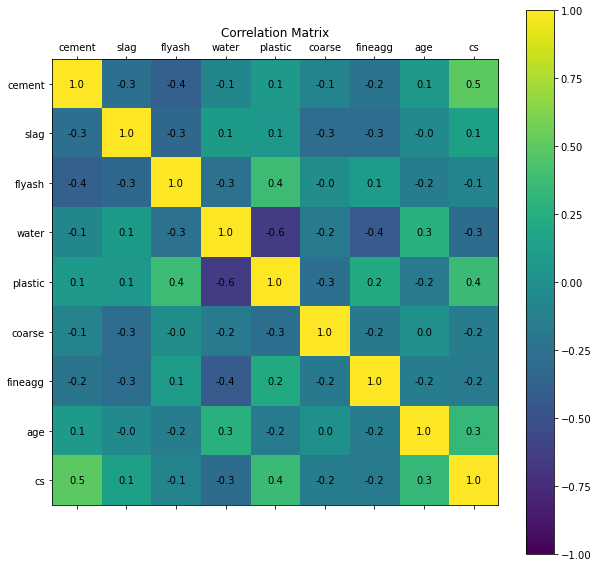

In [10]:
df_mean = my_data.copy(deep=True)                               # deep copy of dataframe
value1 = df_mean.iloc[:,:].values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  # replacing the nan with mean of feature
imputer = imputer.fit(value1)
df_mean .iloc[:,:]= imputer.transform(value1)
my_data = df_mean

corr_matrix = np.corrcoef(my_data, rowvar = False)
plot_corr(my_data,10)                                           # using plot_corr function                         
plt.gcf().set_size_inches((10,10))
plt.show()

The cement, plastic, age possess the high correlation coefficient regarding the response feature (e.g. cs).

### 5. Feature Ranking Using Random Forest
Random forests consist of a lot of decision trees. Each tree is a sequence of yes-no questions based on a single or combination of features. Therefore, the importance of each feature is derived from how impurity (e.g. variance) each of the buckets is. During training it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.

Before training the model, let's do the data splitting

In [11]:
features = my_data.drop('cs', axis = 1)    #  data for predict feature
response = my_data['cs']                   #  data for response feature, removing the column with reponse feature
feature_list = list(features.columns)
train_features, test_features, train_response, test_response = train_test_split(features, response, 
                                                                                test_size = 0.25, random_state = 47) 

Training the first random forest model with default hyperparameters.

Feature: age                  Importance: 0.33
Feature: cement               Importance: 0.31
Feature: water                Importance: 0.12
Feature: slag                 Importance: 0.09
Feature: plastic              Importance: 0.07
Feature: fineagg              Importance: 0.04
Feature: coarse               Importance: 0.03
Feature: flyash               Importance: 0.02


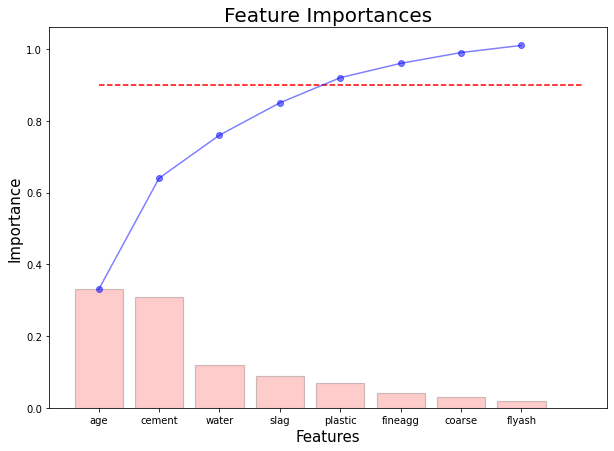

In [12]:
rf = RandomForestRegressor(random_state= 47)  # default setting for first random forest regressor
rf.fit(train_features, train_response)
predictions = rf.predict(test_features)
importances = list(rf.feature_importances_)    # summary the list of feature importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
sorted_importances = [importance[1] for importance in feature_importances]  
sorted_features = [importance[0] for importance in feature_importances]   # sorting importance and corresponding features
cumulative_importances = np.cumsum(sorted_importances)    # getting cumulative_importances from most important feature

plt.bar(sorted_features, sorted_importances, orientation = 'vertical', color = 'r',alpha = 0.2, edgecolor = 'k', linewidth = 1.2)
plt.hlines(y = 0.9, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.plot(sorted_features , cumulative_importances,'o-',color = 'b',alpha = 0.5)
plt.ylabel('Importance',fontsize=15); plt.xlabel('Features',fontsize=15); plt.title('Feature Importances',fontsize=20);
plt.gcf().set_size_inches((10, 7))
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


The model tells us the importance of features in order of age > cement > water > slag > plastic > fineagg > coarse > flyash. Especially, age and cement have significant importance beyond other features. The results are in accord with correlation coefficient analysis. The feature “plastic” is demoted in model-based feature ranking, which may be due to the partial correlation between features.

### 6. Feature Reduction
In the next step, the effect of feature reduction on the bias and variance of the model is conducted. As features are removed based on their importance (e.g., the least important feature is removed first), the changes of MSE, Variance Explained, Accuracy, and running time are recorded. 

[89.35511577781037, 89.26784311345891, 89.02535878804662, 88.46918499352765, 87.80591174710592, 84.5011241076821, 78.60912630987433]
[0.349348783493042, 0.3061716556549072, 0.24733877182006836, 0.25832152366638184, 0.20845437049865723, 0.2094573974609375, 0.16455554962158203]


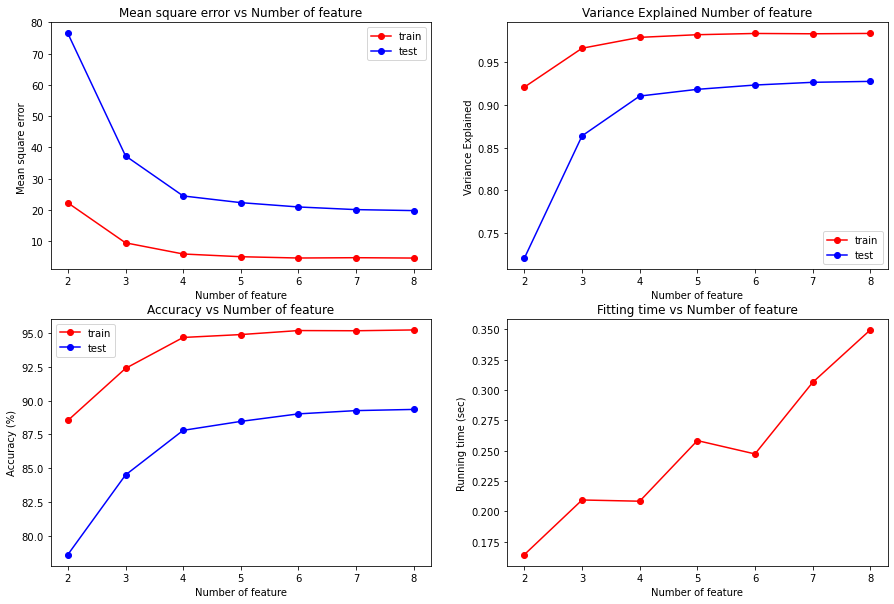

In [20]:
feature_num =[]; MSE_Train =[];MSE_test=[];Var_train=[];Var_test=[];train_accuracy = [];test_accuracy=[]; oob=[]; time_cost =[]  # making empty list of model parameters
response = my_data['cs']   # response feature unchanged

features_8 = features                         # using all features (num =8)
feature_reduction(features_8,response,8)

features_7 = my_data.loc[:,['age','cement','water','slag','plastic','fineagg','coarse']]  # drop the least important feature
feature_reduction(features_7,response,7)

features_6 = my_data.loc[:,['age','cement','water','slag','plastic','fineagg']] # drop another least important feature
feature_reduction(features_6,response,6)

features_5 = my_data.loc[:,['age','cement','water','slag','plastic',]]
feature_reduction(features_5,response,5)

features_4 = my_data.loc[:,['age','cement','water','slag']]
feature_reduction(features_4,response,4)

features_3 = my_data.loc[:,['age','cement','water']]
feature_reduction(features_3,response,3)

features_2 = my_data.loc[:,['age','cement']]
feature_reduction(features_2,response,2)


plt.subplot(221)      # plot 'Mean square error vs %s' % 'Number of feature'
plt.plot(feature_num,MSE_Train, 'ro-',label = 'train')
plt.plot(feature_num,MSE_test, 'bo-',label = 'test')
plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('Mean square error ')
plt.title('Mean square error vs %s' % 'Number of feature')

plt.subplot(222)    # plot 'Variance Explained %s' % 'Number of feature'
plt.plot(feature_num,Var_train, 'ro-',label = 'train')
plt.plot(feature_num,Var_test, 'bo-',label = 'test')
plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('Variance Explained')
plt.title('Variance Explained %s' % 'Number of feature')

plt.subplot(223)   # plot 'Accuracy vs %s' % 'Number of feature'
plt.plot(feature_num,train_accuracy, 'ro-',label = 'train')
plt.plot(feature_num,test_accuracy, 'bo-',label = 'test')
plt.xlabel('Number of feature')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs %s' % 'Number of feature')

plt.subplot(224)   # plot 'Fitting time vs %s' % 'Number of feature'
plt.plot(feature_num,time_cost, 'ro-',label = 'train')   #  make sure no other program is running which may bring error on tracking the fitting time 
plt.xlabel('Number of feature')
plt.ylabel('Running time (sec)')
plt.title('Fitting time vs %s' % 'Number of feature')
plt.gcf().set_size_inches((15, 10))
print(test_accuracy)
print(time_cost)

### Bias and Variance
Bias describes the model’s ability to learn from the training data. A large bias means that the model is having a hard time learning from the training data.

Bias = 1 - train accuarcy

Variance refers to the changes in the model when using different portions of the training data set. We define variance as the difference between the training accuracy and the testing accuracy.

Variance =  train accuary - test acccuary

Generally, MSE, Variance Explained, Accuracy, and Fitting time increase with an increasing number of features. In this case, the improvement of model accuracy is flatted with the five most important features and is affected sightly with residual features, which is due to the decreae of model bias. However, the running time increases dramatically when the number of features continuously increased. Considering the trade-off of the model accuracy and efficiency, the number of features sets to five in the following section. 

### 7. Hyperparameter Tunning

In this step I  tune the  hyperparameters of Random Forest model. RandomForestRegressor contains the following parameters.

* **n_estimators** = number of trees in the foreset
* **max_features** = max number of features considered for splitting a node
* **max_depth** = max number of levels in each decision tree
* **min_samples_split** = min number of data points placed in a node before the node is split
* **min_samples_leaf** = min number of data points allowed in a leaf node

#### 7a Random Search
The benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values on each iteration. In that case, we can narrow the range of hyperparameters for the best model.  More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the running time.The trade-offs of performance vs time is exhibited here.

In [21]:
import warnings
warnings.filterwarnings('ignore')

response = my_data['cs']                                                     # fixing the number of feature equals 5
features_5 = my_data.loc[:,['age','cement','plastic','water','slag']]
train_features, test_features, train_response, test_response = train_test_split(features_5, response, 
                                                                            test_size = 0.25, random_state = 47)
# setting random combination of hyperparameter
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 800, num = 11)]    # Number of trees
max_features = ['sqrt']  # Number of features 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree  (10-110)
min_samples_split = [2, 5, 10]   # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]    # Minimum number of samples in  each leaf node
bootstrap= [True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor(random_state = 47)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,       # setting the n-iter = 100 times
                              n_iter = 100,  cv = 3, verbose=2, random_state=47, n_jobs=-1,  # k-fold Cross-Validation k=3
                              return_train_score=False)  
start_time = time.time()
rf_random.fit(train_features, train_response)
close_time = time.time()
print(rf_random.best_params_)     # obtain the best case of random search
print("cost " +str(close_time - start_time) +" s")   #  show the running time, for 100 n-iter, cost about 1 min

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
cost 90.11860179901123 s


#### 7b Grid Search
After the random search, the grid search is operated with concentrated hyperparameters. Here, we can specify every combination of settings to try and evaluate all combinations. (Note: for demonstration, the combination of hyperparameters is limited, and may miss the perfect results)

In [118]:
# settting grid combination of hyperparameters
gradu_grid = {'n_estimators': [300,350,400,450],
               'max_depth': [80,90,100,110,120],
               'max_features': [2, 3],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [1, 2,3],
               'bootstrap': [True]}
                                   
rf = RandomForestRegressor(random_state = 47)
grid_search = GridSearchCV(estimator = rf, param_grid = gradu_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=False)
start_time = time.time()
grid_search.fit(train_features, train_response)
close_time = time.time()
print(grid_search.best_params_)     # obtain the best case of random search
print("cost "+ str(close_time - start_time) +" s")   #  show the running time, for ~250 n-iter, cost about 2 min

Fitting 3 folds for each of 240 candidates, totalling 720 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
cost 172.9189920425415 s


Now, checked the accuracy and fitting time for best case of Random Search and Grid Search.

In [10]:
rf = RandomForestRegressor(oob_score = True,random_state = 47,n_estimators=400,    # for Random Search
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 'sqrt',max_depth= 110,bootstrap= True)
start_time_Ra = time.time()
rf.fit(train_features, train_response)
close_time_Ra = time.time()
print ("For Random Search, the accuracy is " +str(check_model (rf, train_features, test_features, train_response, test_response)[5]) 
       + "% and the running time is " + str(close_time_Ra -start_time_Ra) +"s" )

rf = RandomForestRegressor(oob_score = True,random_state = 47,n_estimators=300,    # for Grid Search
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 3 ,max_depth= 80,bootstrap= True)
start_time_Gr = time.time()
rf.fit(train_features, train_response)
close_time_Gr = time.time()
grid_accuracy = str(check_model (rf, train_features, test_features, train_response, test_response)[5])
grid_time = str(close_time_Gr -start_time_Gr)
print ("For Grid Search, the accuracy is " +str(check_model (rf, train_features, test_features, train_response, test_response)[5]) 
       + "%, the running time is " + str(close_time_Gr -start_time_Gr) + "s")

For Random Search, the accuracy is 87.15572803691053% and the running time is 0.8734138011932373s
For Grid Search, the accuracy is 88.77440200475849%, the running time is 0.65423583984375s


#### The summary of model accuracy and fitting time

| Model | Setting | Accuracy (%) |  Running time (s) |
| :- | :-: | :-: |:-: |
| Base| 8 features, default hperparameter | 89.35511577781037| 0.349348783493042
| Feature reduced| 5 features, default hperparameter | 88.46918499352765 | 0.25832152366638184
| Feature reduced and tunned| 5 features, tunned hperparameter | 88.77440200475849| 0.65423583984375

After tunning the hyperparameter, the accuracy of the model increases a little bit, but the running time increases a lot. With the number of trees and Max_deep increasing, the improvement of model accuracy is not significant. Moreover, even for Random Forest, a too big number of trees and max_depth can still cause overfitting. 

### 8. The Effect of N_ tree and Max_depth on Model Performance
To understand the effect of the number of trees and max_depth on model error, a combination of n_tree and max_depth is set and the MSE, accuracy of model, and fitting time are shown below.

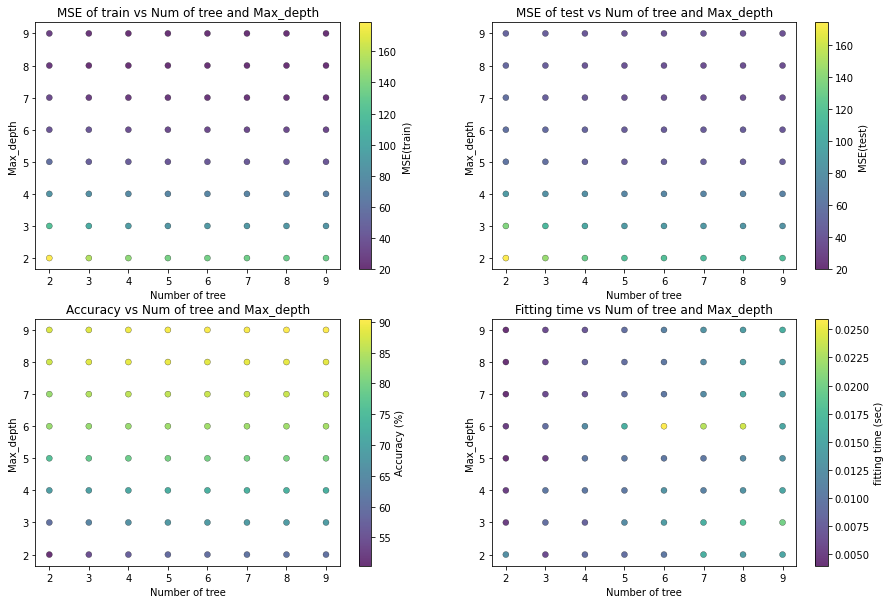

In [22]:
import warnings
warnings.filterwarnings('ignore')
n_tree =[]           # setting empty list of parameters
max_depth= []
time_cost_tune = []
MSE_train =[]
MSE_test =[]
accuracy_tune = []

# the n_tree and max_depth are set at low level of range to show the sensitivity 
for i in range(2, 10):      # loop max_depth (i) in range
    for j in range (2,10):  # loop n_estimators (e.g. number of tree) (j) in range
        rf = RandomForestRegressor(oob_score =True,random_state = 47,n_estimators=j,
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 'sqrt',
                                   max_depth= i,bootstrap= True)
        start_time = time.time()
        rf.fit(train_features, train_response)
        close_time = time.time()
        use_time = close_time-start_time    # otain the elapse time for model calculation
        time_cost_tune.append(use_time)         
        n_tree.append(j)
        max_depth.append(i)
        MSE_train.append(check_model(rf, train_features, test_features, train_response, test_response)[0]) # call check_model function
        MSE_test.append(check_model(rf, train_features, test_features, train_response, test_response)[1])
        accuracy_tune.append((check_model(rf, train_features, test_features, train_response, test_response)[4]))

plt.subplot(221)            #Var of train vs Num of tree and Max_depth                     
im= plt.scatter(n_tree, max_depth,s=None, c=MSE_train , marker=None, cmap=None, norm=None, vmin=20, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('MSE of train vs Num of tree and Max_depth'); plt.xlabel('Number of tree'); plt.ylabel('Max_depth')
cbar = plt.colorbar(im, orientation = 'vertical') 
cbar.set_label("MSE(train)")


plt.subplot(222)            #Var of test vs tree and Max_depth                      
im= plt.scatter(n_tree, max_depth,s=None, c=MSE_test, marker=None, cmap=None, norm=None, vmin=20, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('MSE of test vs Num of tree and Max_depth'); plt.xlabel('Number of tree'); plt.ylabel('Max_depth')
cbar = plt.colorbar(im, orientation = 'vertical') 
cbar.set_label("MSE(test)")


plt.subplot(224)            #Running time vs Num of tree and Max_depth                     
im= plt.scatter(n_tree, max_depth,s=None, c=time_cost_tune, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Fitting time vs Num of tree and Max_depth'); plt.xlabel('Number of tree'); plt.ylabel('Max_depth')
cbar = plt.colorbar(im, orientation = 'vertical') 
cbar.set_label("fitting time (sec)")


plt.subplot(223)            #Accuracy vs Num of tree and Max_depth                       
im= plt.scatter(n_tree, max_depth,s=None, c=accuracy_tune, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Accuracy vs Num of tree and Max_depth'); plt.xlabel('Number of tree'); plt.ylabel('Max_depth')
cbar = plt.colorbar(im, orientation = 'vertical') 
cbar.set_label("Accuracy (%)")

plt.gcf().set_size_inches((15, 10))
plt.show()


As shown in the figure above, both n_tree and max_depth affect the error of the model. when the model is weak (e.g., a small value of n_tree and max_depth). the effect of max_depth is stronger than n_tree. When n_tree is limited, the RandomForest model performs like the decision tree model, which can still make good regression. While the limitation of max_depth could make the prediction closer to being random. 

### 9. The Effect of Bootstrap in Random Forest
Bootstrap is used in the Random Forest model to reduce the model variances. When the bootstrap is set to false, all of the data is used to fit the model and the only variation of model is the random subset of features to try at each split. We expect the bootstrap is so important when the model variance dominates the model error.

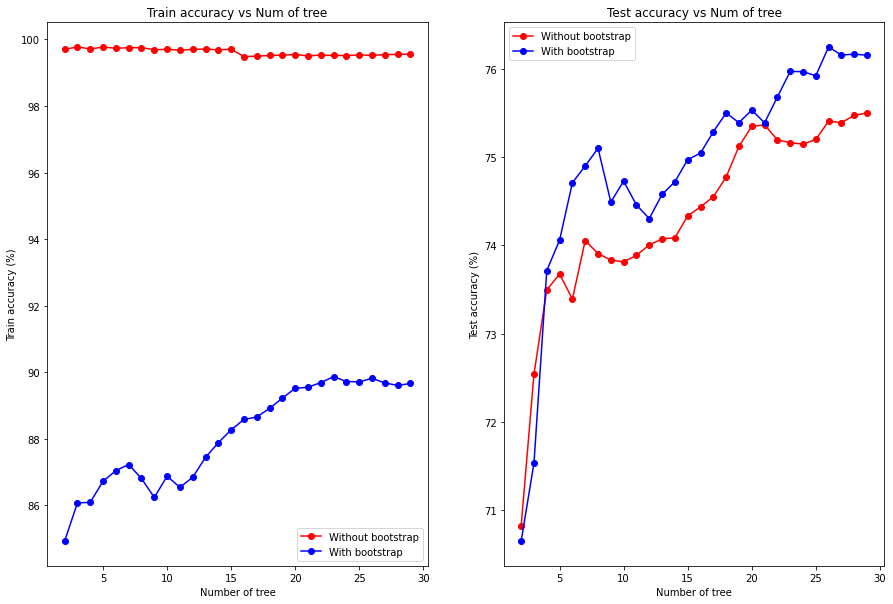

In [23]:
n_tree =[]      # setting for with bootstrap
train_accuracy_list =[]
test_accuracy_list =[]


train_accuracy_nob =[]   # setting for without bootstrap
test_accuracy_nob = []

train_features, test_features, train_response, test_response = train_test_split(features_5, response, 
                                                                            test_size = 0.9, random_state = 47)
                # setting the condition when the number of training data is limited to increase model variance, which dominate the model error
                                                                               

for i in range(2,30):
        n_tree.append(i)
        # When the random forest model without bootstrap
        rf_noboostrap = RandomForestRegressor(random_state = 47,n_estimators=i,
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 'sqrt',max_depth= 10,bootstrap= False)  # bootstrap= False
        rf_noboostrap.fit(train_features, train_response)
        train_predictions_nob = rf_noboostrap.predict(train_features)
        test_predictions_nob = rf_noboostrap.predict(test_features)
        
        test_errors = abs(test_predictions_nob - test_response)      
        test_errors_ave = np.mean(test_errors)
        test_mape = 100 * np.mean(test_errors / test_response)        
        test_accuracy = 100 -test_mape      
        train_errors = abs(train_predictions_nob - train_response)      
        train_errors_ave = np.mean(train_errors)
        train_mape = 100 * np.mean(train_errors / train_response)
        train_accuracy = 100 - train_mape 
        train_accuracy_nob.append(train_accuracy)
        test_accuracy_nob.append(test_accuracy)
        # When the random forest model with bootstrap
        rf = RandomForestRegressor(oob_score = True,random_state = 47,n_estimators=i,
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 'sqrt',max_depth= 10,bootstrap= True)
        rf.fit(train_features, train_response)
        train_accuracy_list.append((check_model(rf, train_features, test_features, train_response, test_response)[4]))
        test_accuracy_list.append((check_model(rf, train_features, test_features, train_response, test_response)[5]))
       
        
plt.subplot(121)
plt.plot( n_tree,train_accuracy_nob, 'ro-',label = 'Without bootstrap')
plt.plot(n_tree,train_accuracy_list, 'bo-',label = 'With bootstrap')
plt.title('Train accuracy vs Num of tree'); plt.xlabel('Number of tree'); plt.ylabel("Train accuracy (%)")
plt.legend()

plt.subplot(122)
plt.plot( n_tree,test_accuracy_nob, 'ro-',label = 'Without bootstrap')
plt.plot( n_tree,test_accuracy_list, 'bo-',label = 'With bootstrap')
plt.title('Test accuracy vs Num of tree'); plt.xlabel('Number of tree'); plt.ylabel("Test accuracy (%)")
plt.legend()

plt.gcf().set_size_inches((15, 10))
plt.show()


As shown above, the bootstrap increases the model bias as the accuracy of training data decreases with the bootstrap. On the other hand, bootstrap decreases the model variance (difference between train and test accuracy) and reduces the overall model error. The effect of bootstrap becomes more positive when increasing the n_tree. 

### 10. The Effect of  Max_features Splitting in Random Forest
In this section, we force the Random forest model to accept the total features during splitting and check its performance.

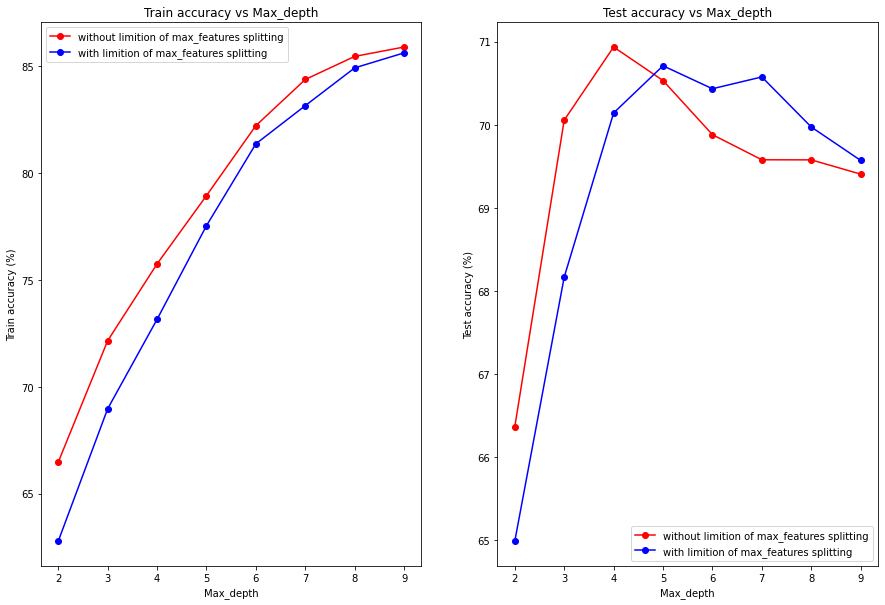

In [24]:
max_depth =[]      # setting for with the limition of max_features splitting
train_accuracy_list =[]
test_accuracy_list =[]

train_accuracy_nop =[]   # setting for without the limition of max_features splitting
test_accuracy_nop = []
                                                         
train_features, test_features, train_response, test_response = train_test_split(features_2, response, 
                                                                                 test_size = 0.9, random_state = 47)
                 # setting the condition when the number of training data is limited to increase model variance
                 # setting the regression based on two features to increase the sensitivity
                                                                               
for i in range(2,10):
        max_depth.append(i)   
        # When the random forest model without the limition of max_features splitting
        rf = RandomForestRegressor(oob_score = True,random_state = 47,n_estimators=20,
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 2,max_depth= i,bootstrap= True)  # 2 features
        rf.fit(train_features, train_response)
        train_accuracy_nop.append((check_model(rf, train_features, test_features, train_response, test_response)[4]))
        test_accuracy_nop.append((check_model(rf, train_features, test_features, train_response, test_response)[5]))
        
        # When the random forest model with the limition of max_features splitting
        rf = RandomForestRegressor(oob_score = True,random_state = 47,n_estimators=20,
                                   min_samples_split= 2,min_samples_leaf= 1,
                                   max_features= 1,max_depth= i,bootstrap= True)   # 1 feature
        rf.fit(train_features, train_response)
        train_accuracy_list.append((check_model(rf, train_features, test_features, train_response, test_response)[4]))
        test_accuracy_list.append((check_model(rf, train_features, test_features, train_response, test_response)[5]))
        
plt.subplot(121)
plt.plot(max_depth, train_accuracy_nop, 'ro-',label = 'without limition of max_features splitting')
plt.plot(max_depth,train_accuracy_list, 'bo-',label = 'with limition of max_features splitting')
plt.title('Train accuracy vs Max_depth'); plt.xlabel('Max_depth'); plt.ylabel("Train accuracy (%)")
plt.legend()

plt.subplot(122)
plt.plot(max_depth,test_accuracy_nop, 'ro-',label = 'without limition of max_features splitting')
plt.plot(max_depth,test_accuracy_list, 'bo-',label = 'with limition of max_features splitting')
plt.title('Test accuracy vs Max_depth'); plt.xlabel('Max_depth'); plt.ylabel("Test accuracy (%)")
plt.legend()

plt.gcf().set_size_inches((15, 10))
plt.show()

As shown above, limitation of Max_features Splitting in Random Forest is another way to decrease the model variance (difference between train and test accuracy) and increase the model accuracy. When the regression is based on two features, the model becomes overfitting when the max_depth is higher than 5.

### Results
1. Based on the built-in function of feature ranking of Random Forest, keeping the 90% accumulation of importance can save 40% of the fitting time, while decrease 1% accuracy.   
2. Hyperparameter tunning is an approach to avoid overfitting in Random Forest, however, it is a time-consuming step with a tradeoff between accuracy and efficiency.
3. The bootstrap and feature splitting in Random Forest enable the mitigation of model variance, which is critically important when the model variance dominates the model error.


Shunxiang Xia

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
